In [1]:
from keras.models import Sequential
from keras.layers import Dense,RepeatVector,Dropout
from keras.layers import Flatten
#from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [2]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [3]:
data = pd.read_csv('PEP.csv')


In [4]:
data

,ticker,date,open,high,low,close
0,PEP,1972-06-01,0.000,1.60,1.580,1.60
1,PEP,1972-06-02,1.600,1.62,1.600,1.60
2,PEP,1972-06-05,1.600,1.60,1.540,1.57
3,PEP,1972-06-06,1.560,1.56,1.560,1.56
4,PEP,1972-06-07,1.560,1.56,1.550,1.55
...,...,...,...,...,...,...
12826,PEP,2023-04-13,182.620,184.61,182.105,184.38
12827,PEP,2023-04-14,183.335,184.02,182.920,183.51
12828,PEP,2023-04-17,184.190,184.75,183.481,184.45
12829,PEP,2023-04-18,184.770,185.22,183.740,184.83


In [5]:
data = data.filter(['close'])


In [6]:
# Lấy 100 dòng cuối cùng của df
data = data.tail(1000)
data

,close
11831,127.24
11832,126.83
11833,127.67
11834,127.27
11835,125.98
...,...
12826,184.38
12827,183.51
12828,184.45
12829,184.83


In [7]:
#Tiền xử lý
data.fillna(0, inplace=True)

# Normalize data
scaler = MinMaxScaler()
dataScale = scaler.fit_transform(data.values.reshape(-1,1))

In [8]:
# Hàm tính giá trị alpha tối ưu
def optimum_alpha(X):
    X_max = np.max(X)
    X_min = np.min(X)
    n = len(X)
    return ((X_max - X_min) - (1/n) * np.sum(X)) / (X_max - X_min)


In [9]:
def smoothed(X, alpha):
    S = np.zeros_like(X)
    S[0] = X[0]
    for i in range(1, len(X)):
        S[i] = S[i-1] + alpha*(X[i] - S[i-1])
    return S

In [10]:
alpha = optimum_alpha(dataScale)


In [11]:
S = smoothed(dataScale, alpha)
print("Giá trị alpha tối ưu:", alpha)
print("Chuỗi ban đầu:", dataScale)
print("Chuỗi đã được làm mịn:", S)


Giá trị alpha tối ưu: 0.4229524216176651
Chuỗi ban đầu: [[0.28437233]
 [0.2793705 ]
 [0.28961815]
 [0.28473832]
 [0.26900085]
 [0.26948884]
 [0.26985482]
 [0.29376601]
 [0.28339636]
 [0.28644626]
 [0.31011346]
 [0.32133707]
 [0.32426497]
 [0.31792119]
 [0.30645358]
 [0.31889716]
 [0.3176772 ]
 [0.31194339]
 [0.28913017]
 [0.29571795]
 [0.30108576]
 [0.29364402]
 [0.30559961]
 [0.30669757]
 [0.33500061]
 [0.34219837]
 [0.36037575]
 [0.3618397 ]
 [0.35708186]
 [0.35634988]
 [0.35390997]
 [0.35134805]
 [0.34878614]
 [0.34317433]
 [0.352812  ]
 [0.36879346]
 [0.36635354]
 [0.36854947]
 [0.36452361]
 [0.34634622]
 [0.33866049]
 [0.33182872]
 [0.34085641]
 [0.34768818]
 [0.36671953]
 [0.35488593]
 [0.34927412]
 [0.33927046]
 [0.37184336]
 [0.37111138]
 [0.35805783]
 [0.36867147]
 [0.36440161]
 [0.35195803]
 [0.35317799]
 [0.31914115]
 [0.32145907]
 [0.32707088]
 [0.30840551]
 [0.30572161]
 [0.33292668]
 [0.33670855]
 [0.32389899]
 [0.29132609]
 [0.28315237]
 [0.29266805]
 [0.24972551]
 [0.27

D:\Download\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Download\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Smooth')

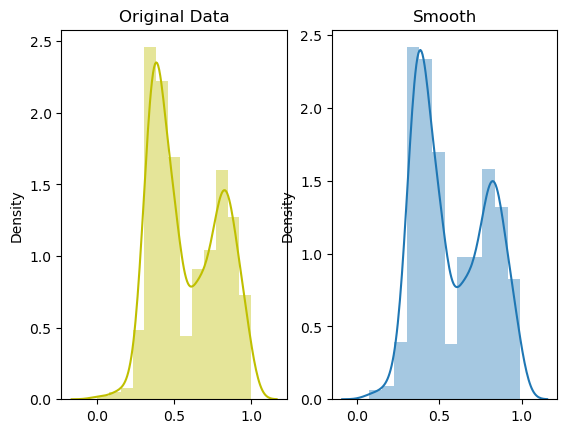

In [12]:
import seaborn as sns

fig, ax=plt.subplots(1,2)
sns.distplot(dataScale, ax=ax[0], color='y')
ax[0].set_title("Original Data")


sns.distplot(S,ax=ax[1])
ax[1].set_title("Smooth")


In [13]:
#Chia dữ liệu thành train test
data = pd.DataFrame(S)

#dataScale = data
train_percent = 0.8
train_size = int(len(data) * train_percent)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [14]:
#Chuẩn bị dữ liệu để đưa vào mô hình
def prepare_data(data, size_window,size_predict,stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
          
       
        startWindow += stepWindow
    return np.array(X), np.array(y)


size_window = 7
size_predict = 1
stepWindow = 1
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test = prepare_data(test_data.values, size_window, size_predict, stepWindow)

In [15]:
start_time = time.time()

In [16]:
start_time = time.time()

# Tạo một list chứa các số Lucas để sử dụng làm số lượng hidden layer
lucas_list = [3, 4, 7, 11, 18, 29, 47, 76]

# Chọn số lượng hidden layer sử dụng theo số Lucas
num_hidden_layer = lucas_list[1] # ví dụ chọn số 11

In [17]:

# Tạo mô hình CNN
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(size_window, 1)))
model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
for i in range(num_hidden_layer):
    model.add(Dense(units=100, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

# Compile mô hình với Adam optimizer và Mean Squared Error loss
model.compile(loss='mse', optimizer='adam')


In [18]:
history = model.fit(X_train, y_train, epochs=9000, batch_size=8)

Epoch 1/9000
99/99 [==============================] - 2s 2ms/step - loss: 0.0667
Epoch 2/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 3/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 4/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 5/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 6/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 7/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 8/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 9/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 10/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 11/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 12/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 13/9000
99/99 [====

Epoch 196/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.8924e-04
Epoch 197/9000
99/99 [==============================] - 0s 2ms/step - loss: 9.9345e-04
Epoch 198/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.7030e-04
Epoch 199/9000
99/99 [==============================] - 0s 2ms/step - loss: 9.7743e-04
Epoch 200/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.6944e-04
Epoch 201/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 202/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.6731e-04
Epoch 203/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.8537e-04
Epoch 204/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.2055e-04
Epoch 205/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 206/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 207/9000
99/99 [==============================] -

99/99 [==============================] - 0s 2ms/step - loss: 8.1076e-04
Epoch 385/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.2940e-04
Epoch 386/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.4793e-04
Epoch 387/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.4122e-04
Epoch 388/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.5413e-04
Epoch 389/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 390/9000
99/99 [==============================] - 0s 2ms/step - loss: 9.0950e-04
Epoch 391/9000
99/99 [==============================] - 0s 2ms/step - loss: 9.1865e-04
Epoch 392/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.1165e-04
Epoch 393/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.7860e-04
Epoch 394/9000
99/99 [==============================] - 0s 2ms/step - loss: 9.2873e-04
Epoch 395/9000
99/99 [==============================] - 0s 2ms

99/99 [==============================] - 0s 2ms/step - loss: 8.0527e-04
Epoch 573/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.8773e-04
Epoch 574/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.3059e-04
Epoch 575/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.0679e-04
Epoch 576/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.9596e-04
Epoch 577/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.6754e-04
Epoch 578/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9380e-04
Epoch 579/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.2172e-04
Epoch 580/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2887e-04
Epoch 581/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6312e-04
Epoch 582/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.7431e-04
Epoch 583/9000
99/99 [==============================] - 0s

99/99 [==============================] - 0s 2ms/step - loss: 8.3637e-04
Epoch 761/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.8074e-04
Epoch 762/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.0246e-04
Epoch 763/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.7452e-04
Epoch 764/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.0588e-04
Epoch 765/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9294e-04
Epoch 766/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.6387e-04
Epoch 767/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5845e-04
Epoch 768/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.9526e-04
Epoch 769/9000
99/99 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 770/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5318e-04
Epoch 771/9000
99/99 [==============================] - 0s 2ms

99/99 [==============================] - 0s 2ms/step - loss: 7.6294e-04
Epoch 949/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.9373e-04
Epoch 950/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.9436e-04
Epoch 951/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2985e-04
Epoch 952/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3282e-04
Epoch 953/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.0010e-04
Epoch 954/9000
99/99 [==============================] - 0s 2ms/step - loss: 9.3927e-04
Epoch 955/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.5750e-04
Epoch 956/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.1940e-04
Epoch 957/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4077e-04
Epoch 958/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6980e-04
Epoch 959/9000
99/99 [==============================] - 0s

99/99 [==============================] - 0s 2ms/step - loss: 7.5562e-04
Epoch 1135/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7556e-04
Epoch 1136/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.4170e-04
Epoch 1137/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.8153e-04
Epoch 1138/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9272e-04
Epoch 1139/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1364e-04
Epoch 1140/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4418e-04
Epoch 1141/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1402e-04
Epoch 1142/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1141e-04
Epoch 1143/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.9464e-04
Epoch 1144/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4781e-04
Epoch 1145/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.0348e-04
Epoch 1321/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4541e-04
Epoch 1322/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.3656e-04
Epoch 1323/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3302e-04
Epoch 1324/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0486e-04
Epoch 1325/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.0858e-04
Epoch 1326/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.8236e-04
Epoch 1327/9000
99/99 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 1328/9000
99/99 [==============================] - 0s 3ms/step - loss: 6.9959e-04
Epoch 1329/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1364e-04
Epoch 1330/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4909e-04
Epoch 1331/9000
99/99 [=============================

99/99 [==============================] - 0s 2ms/step - loss: 6.8252e-04
Epoch 1507/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.4664e-04
Epoch 1508/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6804e-04
Epoch 1509/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6452e-04
Epoch 1510/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0693e-04
Epoch 1511/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4041e-04
Epoch 1512/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0354e-04
Epoch 1513/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3232e-04
Epoch 1514/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6143e-04
Epoch 1515/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6912e-04
Epoch 1516/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7180e-04
Epoch 1517/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.7030e-04
Epoch 1693/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2900e-04
Epoch 1694/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5969e-04
Epoch 1695/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.7992e-04
Epoch 1696/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9317e-04
Epoch 1697/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3345e-04
Epoch 1698/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.8577e-04
Epoch 1699/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2967e-04
Epoch 1700/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3867e-04
Epoch 1701/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5666e-04
Epoch 1702/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7974e-04
Epoch 1703/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.3509e-04
Epoch 1879/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5316e-04
Epoch 1880/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.2336e-04
Epoch 1881/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6955e-04
Epoch 1882/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7628e-04
Epoch 1883/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3769e-04
Epoch 1884/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.0004e-04
Epoch 1885/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3763e-04
Epoch 1886/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0385e-04
Epoch 1887/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0190e-04
Epoch 1888/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.7050e-04
Epoch 1889/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.4265e-04
Epoch 2065/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3004e-04
Epoch 2066/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8537e-04
Epoch 2067/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0613e-04
Epoch 2068/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5868e-04
Epoch 2069/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8854e-04
Epoch 2070/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2828e-04
Epoch 2071/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.1713e-04
Epoch 2072/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9601e-04
Epoch 2073/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3188e-04
Epoch 2074/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8293e-04
Epoch 2075/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.5276e-04
Epoch 2251/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7094e-04
Epoch 2252/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7644e-04
Epoch 2253/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.8561e-04
Epoch 2254/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5482e-04
Epoch 2255/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6786e-04
Epoch 2256/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5953e-04
Epoch 2257/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4444e-04
Epoch 2258/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7230e-04
Epoch 2259/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4546e-04
Epoch 2260/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4773e-04
Epoch 2261/9000
99/99 [=========================

99/99 [==============================] - 0s 3ms/step - loss: 9.2658e-04
Epoch 2437/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8761e-04
Epoch 2438/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6803e-04
Epoch 2439/9000
99/99 [==============================] - 0s 3ms/step - loss: 6.5501e-04
Epoch 2440/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3347e-04
Epoch 2441/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5685e-04
Epoch 2442/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4126e-04
Epoch 2443/9000
99/99 [==============================] - 0s 2ms/step - loss: 9.4780e-04
Epoch 2444/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1894e-04
Epoch 2445/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2872e-04
Epoch 2446/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3339e-04
Epoch 2447/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.8510e-04
Epoch 2623/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2284e-04
Epoch 2624/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3829e-04
Epoch 2625/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6527e-04
Epoch 2626/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7828e-04
Epoch 2627/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7248e-04
Epoch 2628/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5658e-04
Epoch 2629/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0541e-04
Epoch 2630/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2744e-04
Epoch 2631/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2487e-04
Epoch 2632/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0915e-04
Epoch 2633/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.2939e-04
Epoch 2809/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9671e-04
Epoch 2810/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3154e-04
Epoch 2811/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2027e-04
Epoch 2812/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.1317e-04
Epoch 2813/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.7409e-04
Epoch 2814/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2981e-04
Epoch 2815/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1846e-04
Epoch 2816/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2897e-04
Epoch 2817/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9412e-04
Epoch 2818/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0493e-04
Epoch 2819/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.5951e-04
Epoch 2995/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5328e-04
Epoch 2996/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6583e-04
Epoch 2997/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0800e-04
Epoch 2998/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4504e-04
Epoch 2999/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.8313e-04
Epoch 3000/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0167e-04
Epoch 3001/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8184e-04
Epoch 3002/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6038e-04
Epoch 3003/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4010e-04
Epoch 3004/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.1390e-04
Epoch 3005/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.4600e-04
Epoch 3181/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3611e-04
Epoch 3182/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5828e-04
Epoch 3183/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0768e-04
Epoch 3184/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4339e-04
Epoch 3185/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7523e-04
Epoch 3186/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3488e-04
Epoch 3187/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3777e-04
Epoch 3188/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8979e-04
Epoch 3189/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5617e-04
Epoch 3190/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3555e-04
Epoch 3191/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.4206e-04
Epoch 3367/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.5887e-04
Epoch 3368/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7307e-04
Epoch 3369/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0537e-04
Epoch 3370/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0499e-04
Epoch 3371/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5111e-04
Epoch 3372/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6810e-04
Epoch 3373/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3248e-04
Epoch 3374/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4318e-04
Epoch 3375/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7965e-04
Epoch 3376/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2831e-04
Epoch 3377/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.3963e-04
Epoch 3553/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.3213e-04
Epoch 3554/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.5460e-04
Epoch 3555/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.9118e-04
Epoch 3556/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3908e-04
Epoch 3557/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3803e-04
Epoch 3558/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5652e-04
Epoch 3559/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6278e-04
Epoch 3560/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3654e-04
Epoch 3561/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4127e-04
Epoch 3562/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3023e-04
Epoch 3563/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.0923e-04
Epoch 3739/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2546e-04
Epoch 3740/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1243e-04
Epoch 3741/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6297e-04
Epoch 3742/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.1023e-04
Epoch 3743/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2976e-04
Epoch 3744/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2287e-04
Epoch 3745/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8250e-04
Epoch 3746/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.9721e-04
Epoch 3747/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5134e-04
Epoch 3748/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0789e-04
Epoch 3749/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.5759e-04
Epoch 3925/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8796e-04
Epoch 3926/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2993e-04
Epoch 3927/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.7988e-04
Epoch 3928/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4401e-04
Epoch 3929/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2748e-04
Epoch 3930/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1176e-04
Epoch 3931/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6044e-04
Epoch 3932/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2311e-04
Epoch 3933/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5926e-04
Epoch 3934/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6424e-04
Epoch 3935/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.2086e-04
Epoch 4111/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3322e-04
Epoch 4112/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.5766e-04
Epoch 4113/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7558e-04
Epoch 4114/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4314e-04
Epoch 4115/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.9441e-04
Epoch 4116/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9459e-04
Epoch 4117/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.9362e-04
Epoch 4118/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6725e-04
Epoch 4119/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3098e-04
Epoch 4120/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7650e-04
Epoch 4121/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.2893e-04
Epoch 4297/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5592e-04
Epoch 4298/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.7080e-04
Epoch 4299/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2936e-04
Epoch 4300/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.9906e-04
Epoch 4301/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.1378e-04
Epoch 4302/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2771e-04
Epoch 4303/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1850e-04
Epoch 4304/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.6746e-04
Epoch 4305/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5757e-04
Epoch 4306/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9111e-04
Epoch 4307/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.3379e-04
Epoch 4483/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1600e-04
Epoch 4484/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4251e-04
Epoch 4485/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2980e-04
Epoch 4486/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.7711e-04
Epoch 4487/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.7146e-04
Epoch 4488/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5820e-04
Epoch 4489/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1096e-04
Epoch 4490/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0272e-04
Epoch 4491/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.8200e-04
Epoch 4492/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9511e-04
Epoch 4493/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 5.7380e-04
Epoch 4669/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7912e-04
Epoch 4670/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4516e-04
Epoch 4671/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8544e-04
Epoch 4672/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1624e-04
Epoch 4673/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.8323e-04
Epoch 4674/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9440e-04
Epoch 4675/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6513e-04
Epoch 4676/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8611e-04
Epoch 4677/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8549e-04
Epoch 4678/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6277e-04
Epoch 4679/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.5994e-04
Epoch 4855/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3884e-04
Epoch 4856/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0425e-04
Epoch 4857/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8670e-04
Epoch 4858/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0585e-04
Epoch 4859/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6911e-04
Epoch 4860/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4914e-04
Epoch 4861/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2862e-04
Epoch 4862/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7365e-04
Epoch 4863/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7245e-04
Epoch 4864/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7386e-04
Epoch 4865/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.7411e-04
Epoch 5041/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4685e-04
Epoch 5042/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2454e-04
Epoch 5043/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9697e-04
Epoch 5044/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0153e-04
Epoch 5045/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0103e-04
Epoch 5046/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2230e-04
Epoch 5047/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6256e-04
Epoch 5048/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.5120e-04
Epoch 5049/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6794e-04
Epoch 5050/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1211e-04
Epoch 5051/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.0052e-04
Epoch 5227/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7414e-04
Epoch 5228/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2073e-04
Epoch 5229/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4907e-04
Epoch 5230/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5011e-04
Epoch 5231/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4154e-04
Epoch 5232/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3598e-04
Epoch 5233/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2851e-04
Epoch 5234/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6505e-04
Epoch 5235/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.8280e-04
Epoch 5236/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1658e-04
Epoch 5237/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.0302e-04
Epoch 5413/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6741e-04
Epoch 5414/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6269e-04
Epoch 5415/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0990e-04
Epoch 5416/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1509e-04
Epoch 5417/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5462e-04
Epoch 5418/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5783e-04
Epoch 5419/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4545e-04
Epoch 5420/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1036e-04
Epoch 5421/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3341e-04
Epoch 5422/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4114e-04
Epoch 5423/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.7743e-04
Epoch 5599/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0225e-04
Epoch 5600/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2269e-04
Epoch 5601/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1573e-04
Epoch 5602/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0351e-04
Epoch 5603/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1920e-04
Epoch 5604/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1981e-04
Epoch 5605/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.5756e-04
Epoch 5606/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4929e-04
Epoch 5607/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1774e-04
Epoch 5608/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4579e-04
Epoch 5609/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.7138e-04
Epoch 5785/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5784e-04
Epoch 5786/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3161e-04
Epoch 5787/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.6211e-04
Epoch 5788/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2199e-04
Epoch 5789/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6706e-04
Epoch 5790/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0703e-04
Epoch 5791/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2700e-04
Epoch 5792/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3192e-04
Epoch 5793/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6064e-04
Epoch 5794/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3903e-04
Epoch 5795/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 5.9619e-04
Epoch 5971/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5534e-04
Epoch 5972/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.7832e-04
Epoch 5973/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1698e-04
Epoch 5974/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0966e-04
Epoch 5975/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.8790e-04
Epoch 5976/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.7290e-04
Epoch 5977/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6414e-04
Epoch 5978/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2436e-04
Epoch 5979/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2788e-04
Epoch 5980/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.6898e-04
Epoch 5981/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.4414e-04
Epoch 6157/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7583e-04
Epoch 6158/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4978e-04
Epoch 6159/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3632e-04
Epoch 6160/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2103e-04
Epoch 6161/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.7291e-04
Epoch 6162/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4744e-04
Epoch 6163/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7146e-04
Epoch 6164/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1301e-04
Epoch 6165/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1874e-04
Epoch 6166/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9418e-04
Epoch 6167/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.9509e-04
Epoch 6343/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6550e-04
Epoch 6344/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8379e-04
Epoch 6345/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.7731e-04
Epoch 6346/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7421e-04
Epoch 6347/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2335e-04
Epoch 6348/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1193e-04
Epoch 6349/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4210e-04
Epoch 6350/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1226e-04
Epoch 6351/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1983e-04
Epoch 6352/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4716e-04
Epoch 6353/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.1380e-04
Epoch 6529/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.0725e-04
Epoch 6530/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4689e-04
Epoch 6531/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0094e-04
Epoch 6532/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.9357e-04
Epoch 6533/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5234e-04
Epoch 6534/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.6581e-04
Epoch 6535/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8967e-04
Epoch 6536/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.7279e-04
Epoch 6537/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.5352e-04
Epoch 6538/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.7746e-04
Epoch 6539/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.5529e-04
Epoch 6715/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.8867e-04
Epoch 6716/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3786e-04
Epoch 6717/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0986e-04
Epoch 6718/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.1885e-04
Epoch 6719/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8694e-04
Epoch 6720/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4271e-04
Epoch 6721/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9868e-04
Epoch 6722/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3696e-04
Epoch 6723/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3187e-04
Epoch 6724/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.2032e-04
Epoch 6725/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.3836e-04
Epoch 6901/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.8935e-04
Epoch 6902/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.8580e-04
Epoch 6903/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6806e-04
Epoch 6904/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.7418e-04
Epoch 6905/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6295e-04
Epoch 6906/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4504e-04
Epoch 6907/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6041e-04
Epoch 6908/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6619e-04
Epoch 6909/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9627e-04
Epoch 6910/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3344e-04
Epoch 6911/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.7413e-04
Epoch 7087/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.8177e-04
Epoch 7088/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4708e-04
Epoch 7089/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0378e-04
Epoch 7090/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.2112e-04
Epoch 7091/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3627e-04
Epoch 7092/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1347e-04
Epoch 7093/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0185e-04
Epoch 7094/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3692e-04
Epoch 7095/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7084e-04
Epoch 7096/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1282e-04
Epoch 7097/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.8564e-04
Epoch 7273/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7197e-04
Epoch 7274/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7142e-04
Epoch 7275/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0197e-04
Epoch 7276/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4150e-04
Epoch 7277/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8420e-04
Epoch 7278/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.9422e-04
Epoch 7279/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2777e-04
Epoch 7280/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6730e-04
Epoch 7281/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.3485e-04
Epoch 7282/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4561e-04
Epoch 7283/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.9880e-04
Epoch 7459/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.1674e-04
Epoch 7460/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8343e-04
Epoch 7461/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6176e-04
Epoch 7462/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.6639e-04
Epoch 7463/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6678e-04
Epoch 7464/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3865e-04
Epoch 7465/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6872e-04
Epoch 7466/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3760e-04
Epoch 7467/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.7566e-04
Epoch 7468/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5552e-04
Epoch 7469/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.2696e-04
Epoch 7645/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6333e-04
Epoch 7646/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7544e-04
Epoch 7647/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7886e-04
Epoch 7648/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5170e-04
Epoch 7649/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1372e-04
Epoch 7650/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8121e-04
Epoch 7651/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8651e-04
Epoch 7652/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6704e-04
Epoch 7653/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1735e-04
Epoch 7654/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4560e-04
Epoch 7655/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.3971e-04
Epoch 7831/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.8198e-04
Epoch 7832/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4866e-04
Epoch 7833/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3453e-04
Epoch 7834/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1494e-04
Epoch 7835/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4768e-04
Epoch 7836/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6484e-04
Epoch 7837/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8361e-04
Epoch 7838/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1529e-04
Epoch 7839/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3500e-04
Epoch 7840/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2973e-04
Epoch 7841/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.4159e-04
Epoch 8017/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6569e-04
Epoch 8018/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.9600e-04
Epoch 8019/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8410e-04
Epoch 8020/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0477e-04
Epoch 8021/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2289e-04
Epoch 8022/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0689e-04
Epoch 8023/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3854e-04
Epoch 8024/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.9855e-04
Epoch 8025/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4057e-04
Epoch 8026/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0160e-04
Epoch 8027/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 7.7073e-04
Epoch 8203/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7631e-04
Epoch 8204/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.3934e-04
Epoch 8205/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4411e-04
Epoch 8206/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3053e-04
Epoch 8207/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5143e-04
Epoch 8208/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.6397e-04
Epoch 8209/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5413e-04
Epoch 8210/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0129e-04
Epoch 8211/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2833e-04
Epoch 8212/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.6253e-04
Epoch 8213/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 5.3825e-04
Epoch 8389/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.4839e-04
Epoch 8390/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6865e-04
Epoch 8391/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7202e-04
Epoch 8392/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.1904e-04
Epoch 8393/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.7623e-04
Epoch 8394/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.9909e-04
Epoch 8395/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2550e-04
Epoch 8396/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4728e-04
Epoch 8397/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6715e-04
Epoch 8398/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2097e-04
Epoch 8399/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 5.8885e-04
Epoch 8575/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2510e-04
Epoch 8576/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0853e-04
Epoch 8577/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0446e-04
Epoch 8578/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2179e-04
Epoch 8579/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5418e-04
Epoch 8580/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.9409e-04
Epoch 8581/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3140e-04
Epoch 8582/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5726e-04
Epoch 8583/9000
99/99 [==============================] - 0s 2ms/step - loss: 5.9332e-04
Epoch 8584/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3452e-04
Epoch 8585/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 6.7165e-04
Epoch 8761/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2929e-04
Epoch 8762/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3687e-04
Epoch 8763/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2029e-04
Epoch 8764/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.5553e-04
Epoch 8765/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3228e-04
Epoch 8766/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.4502e-04
Epoch 8767/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6378e-04
Epoch 8768/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2395e-04
Epoch 8769/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.2709e-04
Epoch 8770/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.0487e-04
Epoch 8771/9000
99/99 [=========================

99/99 [==============================] - 0s 2ms/step - loss: 5.6493e-04
Epoch 8947/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.3117e-04
Epoch 8948/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.8362e-04
Epoch 8949/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.3833e-04
Epoch 8950/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.6202e-04
Epoch 8951/9000
99/99 [==============================] - 0s 2ms/step - loss: 8.2586e-04
Epoch 8952/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.1984e-04
Epoch 8953/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9611e-04
Epoch 8954/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.0572e-04
Epoch 8955/9000
99/99 [==============================] - 0s 2ms/step - loss: 6.9356e-04
Epoch 8956/9000
99/99 [==============================] - 0s 2ms/step - loss: 7.5172e-04
Epoch 8957/9000
99/99 [=========================

In [19]:
y_pred = model.predict(X_test)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

6/6 [==============================] - 0s 1ms/step
Training time: 1775.0265865325928 seconds


In [20]:
import h5py

# Lưu mô hình CNN
model.save("PEP_SCNN_82.h5")

# Lưu các thông tin khác vào file H5
with h5py.File("PEP_SCNN_82_data.h5", "w") as file:
    file.create_dataset("y_test", data=y_test)
    file.create_dataset("X_test", data=X_test)
    file.create_dataset("training_time", data=training_time)
    file.create_dataset("alpha", data=alpha)
    file.create_dataset("S", data=S)
    file.create_dataset("dataScale", data =dataScale)
